In [2]:
# Run this cell to upload your kaggle.json file
from google.colab import files
import os

# Prompt to upload the file
uploaded = files.upload()

# Set up the Kaggle directory and permissions
if 'kaggle.json' in uploaded:
    !mkdir -p ~/.kaggle
    !mv kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("Kaggle API token configured successfully!")
else:
    print("kaggle.json not found. Please upload the file.")

Saving kaggle.json to kaggle.json
Kaggle API token configured successfully!


In [2]:
!pip install kagglehub datasets -q

In [4]:
import kagglehub
import os
from datasets import load_dataset

print("Downloading dataset from Kaggle...")
# This downloads the files and returns the root path where they are stored
dataset_path = kagglehub.dataset_download("shaunthesheep/microsoft-catsvsdogs-dataset")
print(f"Dataset downloaded to: {dataset_path}")

# 3. Construct the full path to the image folder
# The images are inside the 'PetImages' subdirectory
image_folder_path = os.path.join(dataset_path, "PetImages")

# 4. Load the dataset using the "imagefolder" builder from Hugging Face
# This tells the library to treat the directory as an image dataset
print("Loading images into Hugging Face Dataset...")
hf_dataset = load_dataset("imagefolder", data_dir=image_folder_path)

print("\n✅ Successfully loaded as a Hugging Face Dataset:")
print(hf_dataset)

Using Colab cache for faster access to the 'microsoft-catsvsdogs-dataset' dataset.
Dataset downloaded to: /kaggle/input/microsoft-catsvsdogs-dataset
Loading images into Hugging Face Dataset...


Resolving data files:   0%|          | 0/25002 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]


✅ Successfully loaded as a Hugging Face Dataset:
DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 25000
    })
})


In [5]:
# License: BSD
# Author: Sasank Chilamkurthy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory
from torch.utils.data import DataLoader, random_split

cudnn.benchmark = True
plt.ion()   # interactive mode

In [6]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
base_data_dir = '/kaggle/input/microsoft-catsvsdogs-dataset/PetImages'
train_dataset_full = datasets.ImageFolder(base_data_dir, transform=data_transforms['train'])
val_dataset_full   = datasets.ImageFolder(base_data_dir, transform=data_transforms['val'])

train_size = int(0.8 * len(train_dataset_full))
val_size   = len(train_dataset_full) - train_size


indices = torch.randperm(len(train_dataset_full))
train_idx = indices[:train_size]
val_idx   = indices[train_size:]
train_dataset = torch.utils.data.Subset(train_dataset_full, train_idx)
val_dataset   = torch.utils.data.Subset(val_dataset_full, val_idx)

# --- 5. Apply the VAL Transforms to the Validation Subset ---
# Since random_split creates a Subset object, we can override its transform.
# This ensures validation data is not augmented with RandomResizedCrop/Flip.
val_dataset.dataset.transform = data_transforms['val']


# --- 6. Create the Dataloaders ---
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4) # typically no shuffle for val
}

# --- 7. Update Dataset Sizes and Class Names ---
dataset_sizes = {'train': len(train_dataset), 'val': len(val_dataset)}
class_names = train_dataset_full.classes

print("Class Names:", class_names)
print("Training Size:", dataset_sizes['train'])
print("Validation Size:", dataset_sizes['val'])
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Class Names: ['Cat', 'Dog']
Training Size: 20000
Validation Size: 5000
Using cuda device


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


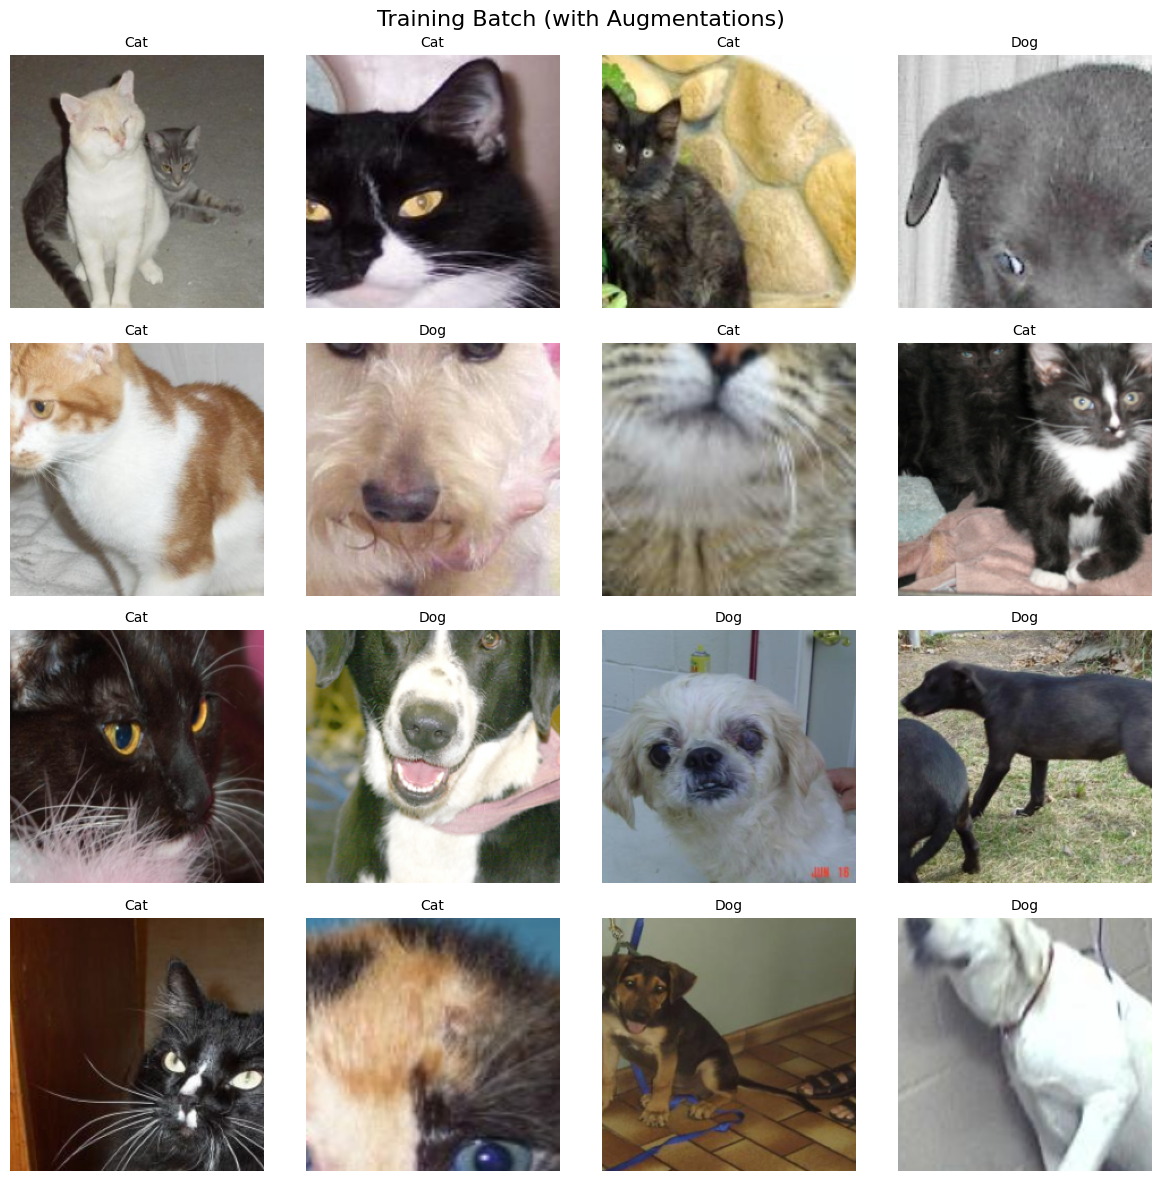

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

def show_batch(dataloader, class_names, n_images=16, title="Sample Training Images"):
    """Display a batch of images with their labels in a clean grid."""
    # Get one batch
    inputs, classes = next(iter(dataloader))

    # Make sure we don’t go over the number of images in the batch
    n_images = min(n_images, inputs.size(0))

    # Create a figure
    cols = 4
    rows = n_images // cols + int(n_images % cols != 0)
    plt.figure(figsize=(cols * 3, rows * 3))
    plt.suptitle(title, fontsize=16)

    # Unnormalize function
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    for i in range(n_images):
        ax = plt.subplot(rows, cols, i + 1)
        img = inputs[i].numpy().transpose((1, 2, 0))
        img = std * img + mean
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(class_names[classes[i]], fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
show_batch(dataloaders['train'], class_names, n_images=16, title="Training Batch (with Augmentations)")
